<a href="https://colab.research.google.com/github/macscheffer/DS-Sprint-01-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
# time series https://nbviewer.jupyter.org/github/changhiskhan/talks/blob/master/pydata2012/pandas_timeseries.ipynb

df = pd.read_csv('https://raw.githubusercontent.com/changhiskhan/talks/master/pydata2012/data.csv')
df.head()

,Date,Time,Price,Volume,Exchange Code,Sales Condition,Correction Indicator,Sequence Number,Trade Stop Indicator,Source of Trade,MDS 127 / TRF (Trade Reporting Facility) (*),Exclude Record Flag,Filtered Price
0,11/01/2011,08:04:56.364,104.55,100,P,T,0,196,N,C,NaN,NaN,NaN
1,11/01/2011,08:53:07.459,104.43,150,T,FT,0,316,N,C,NaN,NaN,NaN
2,11/01/2011,08:53:09.284,104.43,100,T,FT,0,317,N,C,NaN,NaN,NaN
3,11/01/2011,08:54:03.921,104.50,100,P,FT,0,318,N,C,NaN,NaN,NaN
4,11/01/2011,08:58:06.162,104.46,1000,Z,T,0,322,N,C,NaN,NaN,NaN


In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/changhiskhan/talks/master/pydata2012/data.csv',
                parse_dates={'Timestamp': ['Date', 'Time']},
                index_col='Timestamp')

df.head()

,Price,Volume,Exchange Code,Sales Condition,Correction Indicator,Sequence Number,Trade Stop Indicator,Source of Trade,MDS 127 / TRF (Trade Reporting Facility) (*),Exclude Record Flag,Filtered Price
Timestamp,,,,,,,,,,,
2011-11-01 08:04:56.364,104.55,100,P,T,0,196,N,C,NaN,NaN,NaN
2011-11-01 08:53:07.459,104.43,150,T,FT,0,316,N,C,NaN,NaN,NaN
2011-11-01 08:53:09.284,104.43,100,T,FT,0,317,N,C,NaN,NaN,NaN
2011-11-01 08:54:03.921,104.50,100,P,FT,0,318,N,C,NaN,NaN,NaN
2011-11-01 08:58:06.162,104.46,1000,Z,T,0,322,N,C,NaN,NaN,NaN


In [23]:
ticks = df.loc[:,['Price', 'Volume']]
ticks.head()

,Price,Volume
Timestamp,,
2011-11-01 08:04:56.364,104.55,100
2011-11-01 08:53:07.459,104.43,150
2011-11-01 08:53:09.284,104.43,100
2011-11-01 08:54:03.921,104.50,100
2011-11-01 08:58:06.162,104.46,1000


In [24]:
# ohlc => open, high, low, close
bars = ticks.Price.resample('1min',how='ohlc')
bars.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ohlc()
  """Entry point for launching an IPython kernel.


,open,high,low,close
Timestamp,,,,
2011-11-01 08:04:00,104.55,104.55,104.55,104.55
2011-11-01 08:05:00,NaN,NaN,NaN,NaN
2011-11-01 08:06:00,NaN,NaN,NaN,NaN
2011-11-01 08:07:00,NaN,NaN,NaN,NaN
2011-11-01 08:08:00,NaN,NaN,NaN,NaN


In [25]:
minute_range = bars.high - bars.low
minute_range.describe()

count    1104.000000
mean        0.017898
std         0.018568
min         0.000000
25%         0.000875
50%         0.013900
75%         0.029000
max         0.150000
dtype: float64

In [26]:
minute_return = bars.close / bars.open - 1
minute_return.describe()

count    1104.000000
mean        0.000003
std         0.000191
min        -0.001442
25%        -0.000096
50%         0.000000
75%         0.000096
max         0.000962
dtype: float64

In [0]:
volume = ticks.Volume.resample('1min').sum()
value = ticks.prod(axis=1).resample('1min').sum()
vwap = value / volume

In [30]:
vwap.loc['2011-11-01 09:27':'2011-11-01 09:32']

Timestamp
2011-11-01 09:27:00           NaN
2011-11-01 09:28:00    104.170000
2011-11-01 09:29:00    103.300800
2011-11-01 09:30:00    104.231368
2011-11-01 09:31:00    104.236679
2011-11-01 09:32:00    104.210000
Freq: T, dtype: float64

In [31]:
bars.open.at_time('9:30')

Timestamp
2011-11-01 09:30:00    104.23
2011-11-02 09:30:00    103.90
2011-11-03 09:30:00    103.80
Freq: 1440T, Name: open, dtype: float64

In [32]:
bars.close.at_time('16:00')

Timestamp
2011-11-01 16:00:00    104.57
2011-11-02 16:00:00    104.29
2011-11-03 16:00:00    103.86
Freq: 1440T, Name: close, dtype: float64

In [34]:
filtered = vwap.between_time('10:00','16:00')
filtered.head()

Timestamp
2011-11-01 10:00:00    104.245387
2011-11-01 10:01:00    104.170771
2011-11-01 10:02:00    104.170000
2011-11-01 10:03:00    104.160952
2011-11-01 10:04:00    104.110870
dtype: float64

In [36]:
vol = volume.between_time('10:00', '16:00')
vol.head()

Timestamp
2011-11-01 10:00:00    18767
2011-11-01 10:01:00    67287
2011-11-01 10:02:00     2000
2011-11-01 10:03:00     2100
2011-11-01 10:04:00     2300
Name: Volume, dtype: int64

In [38]:
filtered.loc['2011-11-03':'2011-11-04'].tail()

Timestamp
2011-11-03 15:56:00    103.830000
2011-11-03 15:57:00    103.834902
2011-11-03 15:58:00    103.826479
2011-11-03 15:59:00    103.831087
2011-11-03 16:00:00    103.800235
dtype: float64

In [39]:
filtered.loc[:'2011-11-04'].head()

Timestamp
2011-11-01 10:00:00    104.245387
2011-11-01 10:01:00    104.170771
2011-11-01 10:02:00    104.170000
2011-11-01 10:03:00    104.160952
2011-11-01 10:04:00    104.110870
dtype: float64

In [0]:
# Leading / Lagging

In [41]:
ticks.head()

,Price,Volume
Timestamp,,
2011-11-01 08:04:56.364,104.55,100
2011-11-01 08:53:07.459,104.43,150
2011-11-01 08:53:09.284,104.43,100
2011-11-01 08:54:03.921,104.50,100
2011-11-01 08:58:06.162,104.46,1000


In [42]:
ticks.shift(1).head()

,Price,Volume
Timestamp,,
2011-11-01 08:04:56.364,NaN,NaN
2011-11-01 08:53:07.459,104.55,100.0
2011-11-01 08:53:09.284,104.43,150.0
2011-11-01 08:54:03.921,104.43,100.0
2011-11-01 08:58:06.162,104.50,100.0


In [43]:
ticks.head()

,Price,Volume
Timestamp,,
2011-11-01 08:04:56.364,104.55,100
2011-11-01 08:53:07.459,104.43,150
2011-11-01 08:53:09.284,104.43,100
2011-11-01 08:54:03.921,104.50,100
2011-11-01 08:58:06.162,104.46,1000


In [44]:
# tshift manipulates the index values.

ticks.tshift(1, 'min').head()

,Price,Volume
Timestamp,,
2011-11-01 08:05:56.364,104.55,100
2011-11-01 08:54:07.459,104.43,150
2011-11-01 08:54:09.284,104.43,100
2011-11-01 08:55:03.921,104.50,100
2011-11-01 08:59:06.162,104.46,1000


In [0]:
# i get the gist of time series data now. 
# i want to understand creating classes. 

# https://nbviewer.jupyter.org/github/lgiordani/blog_source/blob/master/pelican/content/notebooks/Python_3_OOP_Part_2__Classes_and_members.ipynb

In [0]:
class Door:
  def __init__(self, number, status):
    self.number = number
    self.status = status
    
  def open(self):
    self.status = 'open'
    
  def close(self):
    self.status = 'closed'

In [0]:
door1 = Door(1,'closed')
door2 = Door(1,'closed')

In [53]:
hex(id(door1))

'0x7fc435efc1d0'

In [54]:
hex(id(door2))

'0x7fc435efc198'

In [0]:
# the above just shows that even though the two instances have the same attributes, they are seperate and unrelated.

In [0]:
class Door:
  
  color = 'brown'
  
  def __init__(self, number, status):
    self.number = number
    self.status = status
    
  def open(self):
    self.status = 'open'
    
  def close(self):
    self.status = 'closed'

In [57]:
# notice the color attribute is not created using self so it is contained in the class and shared among instances.

Door.color

'brown'

In [59]:
door1 = Door(1,'closed')
door2 = Door(1,'closed')
door1.color

'brown'

In [60]:
door2.color

'brown'

In [61]:
Door.color = 'White'
Door.color

'White'

In [62]:
door1.color

'White'

In [63]:
door2.color

'White'

In [0]:
# https://elitedatascience.com/python-seaborn-tutorial
# seaborn tutorial
import seaborn as sns

In [73]:
df = pd.read_csv('https://gist.githubusercontent.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6/raw/92200bc0a673d5ce2110aaad4544ed6c4010f687/pokemon.csv')
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


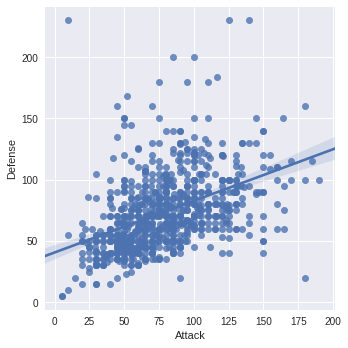

In [76]:
sns.lmplot(x='Attack', y='Defense', data=df)

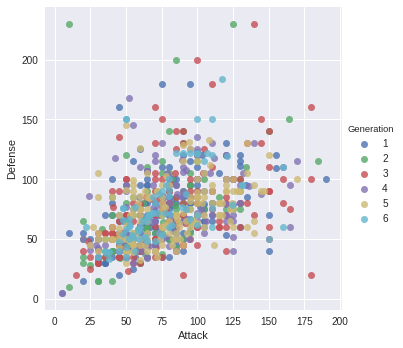

In [78]:
sns.lmplot(x='Attack', y='Defense', data=df,
           fit_reg=False, # no regression line
           hue='Generation') #color by evolution stage

(0, 201.81293602778956)

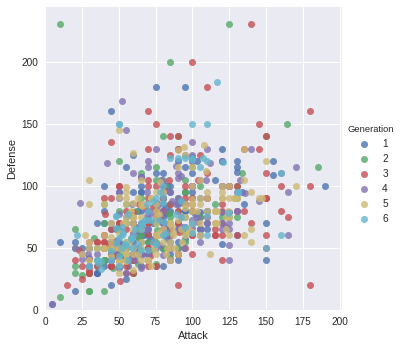

In [81]:
sns.lmplot(x='Attack', y='Defense', data=df,
           fit_reg=False, # no regression line
           hue='Generation') #color by evolution stage

plt.ylim(0, None)
plt.xlim(0, None)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


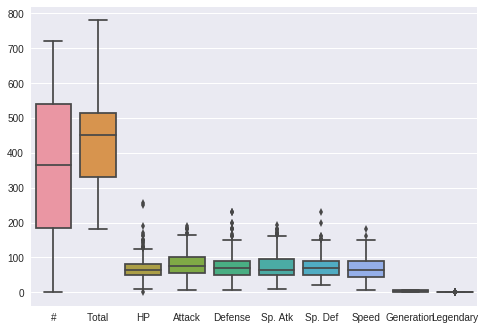

In [82]:
sns.boxplot(data=df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


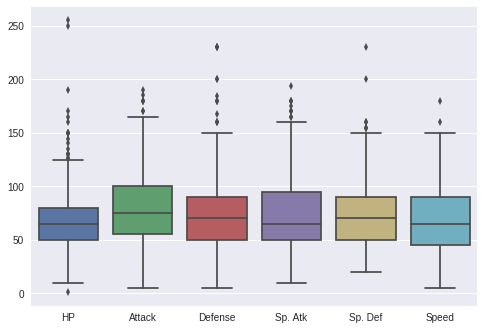

In [84]:
stats_df = df.drop(['#', 'Total', 'Generation', 'Legendary'], axis=1)

sns.boxplot(data=stats_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


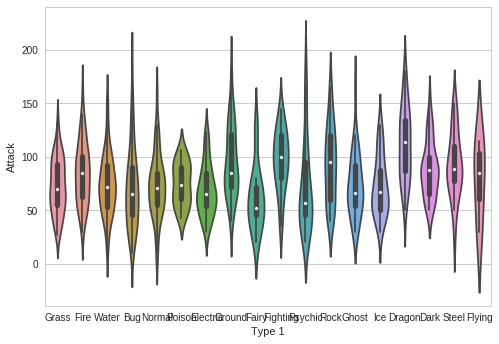

In [85]:
sns.set_style('whitegrid')
sns.violinplot(x='Type 1', y='Attack', data=df)

In [0]:
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


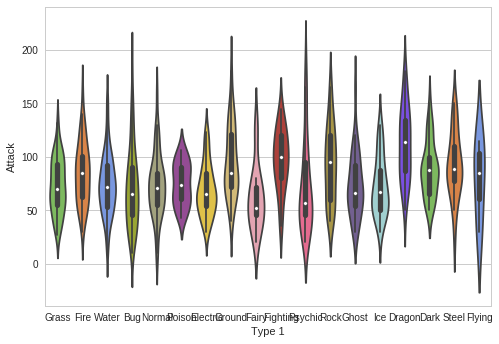

In [89]:
sns.violinplot(x='Type 1', y='Attack', data=df,
              palette=pkmn_type_colors) # setting color pallete

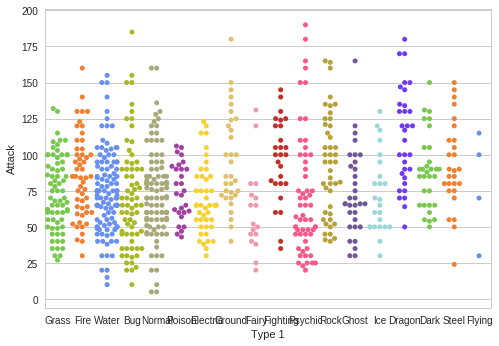

In [90]:
sns.swarmplot(x='Type 1', y='Attack', data=df, 
              palette=pkmn_type_colors)

In [0]:
# overlaying plots. 



### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about